# Computer Vision - Assignment 2 - Convolutional Neural Networks for Image Classification

#### 10 (+3) points   |   Due date: November 25 23:59   |   Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: <mark>Ignacio Garach Vélez</mark>

The goal of this assignment is to learn how to implement and use CNN models using the Fastai library. 

The goal of this assignmnet is to gain experience designing and training convolutional neural networks, using fast.ai. From a base network architecture that is provided, you have to learn to experiment with it and improve it by adding, modifying or deleting layers from this architecture in the task of classifying images into 25 categories. To carry out this assignment, a help guide is provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

En primer lugar cargamos las librerías e instalamos fastai y fastbook.

In [ ]:
import sys
import subprocess
import pkg_resources

required = {'nbdev', 'fastbook'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
print(missing)

if 'nbdev' in missing:
    print("INSTALLING nbdev")
    !pip install nbdev
!pip list |grep nbdev    
if 'fastbook' in missing:
    print("INSTALLING fastbook")
    !pip install -Uqq fastbook
!pip list |grep fastbook

{'fastbook', 'nbdev'}
INSTALLING nbdev
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 78 kB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 47.2 MB/s 
nbdev                         2.3.9
INSTALLING fastbook
     |████████████████████████████████| 719 kB 9.3 MB/s 
     |████████████████████████████████| 1.3 MB 54.2 MB/s 
     |████████████████████████████████| 451 kB 68.6 MB/s 
     |████████████████████████████████| 5.5 MB 49.4 MB/s 
     |████████████████████████████████| 182 kB 65.4 MB/s 
     |████████████████████████████████| 212 kB 73.5 MB/s 
     |████████████████████████████████| 115 kB 67.9 MB/s 
     |████████████████████████████████| 127 kB 64.5 MB/s 
     |████████████████████████████████| 7.6 MB 58.5 MB/s 
fastbook                      0.0.29


In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

Mounted at /content/gdrive
fastcore version 1.5.27 installed
fastai version 2.7.10 installed


In [ ]:
# Function to display evaluation metrics

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
import torch
torch.manual_seed(2020)



---



---



---



# **Exercise 1:** BaseNet in CIFAR100 (4 points)

*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset. This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, the training set has 12,500 images and the test set 2,500 images. 10% of the training set will be used for validation. 

**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements. In order to create it (and later improve it), we will use a sensible combination of the following layers:
- Convolutional layers (Conv2D, either normal or atrous), 
- Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), 
- Dense layers (also called fully connected layers), 
- Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), 
- Flattening (i.e. convert 2D features to 1D features),  
- Batch Normalization, 
- and Regularization (e.g. Dropout or weight decay).

Our BaseNet model consists of two convolutional layers (conv-relu) at different scales (MaxPooling2D), and one head composed of two linear layers (i.e. two dense layers). The precise architecture is defined in the table below:

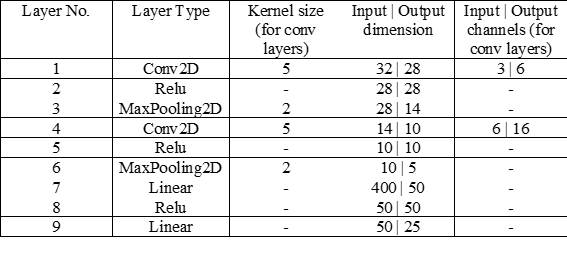

The students must:

1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library, and using any of the techniques shown in the help guide.
2. Train the model and compute the values of “accuracy” and loss function for both training and test sets. Present the results using the provided functions.

Descargamos el dataset y almacenamos la ruta para usarla despues.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets: 
# separate folders for the training set and the validation set (and/or test set). 
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/flowers'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

In [ ]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Total training images:  50000
Total test images:  10000


We now keep the first 25 classes. To do so, we remove the last 75 from the dataset.

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASSES DELETED:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i]) 
print('SUPERCLASSES KEPT:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASSES DELETED:
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/household_electrical_devices
SUPERCLASSES KEPT:
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/d

In [ ]:
# We also remove the same superclasses from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i]) 

/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/trees
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/household_electrical_devices


Now we verify if we have removed them correctly. 

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


And that the number of examples is correct

In [ ]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Total training images:  12500
Total test images:  2500


Now we should have 12500 images for training and 2500 images for testing. 

## Carga de datos mediante la librería fastai

Usamos el objeto DataBlock y cargamos los datos mediante el dataloader, usaremos el método de partición RandomSplitter para separar un 10 por ciento de los datos para validación, además fijamos una semilla para la aleatoriedad.

Setting-up type transforms pipelines
Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/raccoon/raccoon_s_000017.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/raccoon/raccoon_s_000017.png
    applying parent_label gives
      raccoon
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(15)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(15))


Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None,

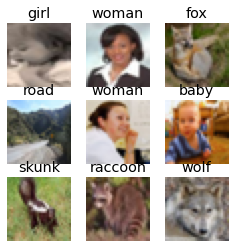

In [ ]:
from fastai.data.external import untar_data, URLs 
# Datablock definition from a set of functions
reducedcifar = DataBlock(blocks    = (ImageBlock, CategoryBlock), # define the type of data block
                   get_items = get_image_files, # read all images in subfolders
                   get_y     = parent_label, # create the labels
                   splitter  = RandomSplitter(valid_pct=0.1, seed=2022)) #split the block for training and test/validation) # resize all images to the same size
# Data load
reducedcifardl = reducedcifar.dataloaders(path/'train') # dowload tha dataset and use the DataBlock definition to create the training dataset
# 
reducedcifardl.show_batch(max_n=9, figsize=(4,4)) # shows a batch of images
#
# if something was wrong, this gives us a summary
reducedcifar.summary(path/'train')
#

In [ ]:
# LET'S START CHECKING THE SIZE OF A TENSOR
data,label=reducedcifardl.one_batch()
print(f'tensor data size{data.shape}','label data size{label.shape}')
print(f'This means a tensor of {data.shape[0]} items, where each item has {data.shape[1]} channels of size [{data.shape[2]},{data.shape[3]}]')

tensor data sizetorch.Size([64, 3, 32, 32]) label data size{label.shape}
This means a tensor of 64 items, where each item has 3 channels of size [32,32]


## Primera aproximación : baseNet

Usaremos la estructura que proporciona el enunciado para crear este modelo que servirá de Baseline para posteriores mejoras. 
A continuación explicamos las distintas capas: 
- - -

**Capa convolucional 1**: A partir de los 3 canales de entrada de la imagen, genera 6 mapas de características mediante kernels de tamaño 5x5.

**Activación No lineal ReLU**: Función de activación más usada, es necesaria para poder aprender redes profundas, las habitualies sigmoidales o hiperbólicas generan problemas en la transmisión del gradiente durante la optimización. Estas capas son fundamentales para el aprendizaje, sin ellas el modelo sería una complicado conjunto de transformaciones de datos.

**Capa de Max Pooling 1**: Reduce la dimensión resumiendo la información de las ventanas de tamaño 2x2 como el máximo de los valores de las mismas.

**Capa convolucional 2**: A partir de los 6 mapas de características de la imagen, genera otros 16 nuevos mapas mediante kernels de tamaño 5x5.

**Activación No lineal ReLU**

**Capa de Max Pooling 2**

**Flatten**: Vectoriza a 1 dimensión los valores para pasarlos a las capas totalmente conectadas.

Finalmente se añaden capas de redes neuronales convencionales con activaciones ReLU, la arquitectura consta de 2 capas de neuronas, la primera tiene 50 neuronas que reciben cada una de las 400 entradas y la segunda 25 neuronas, finalmente, torch añade automáticamente un Softmax para el problema de clasificación multiclase.

En total la red debe ajustar 24197 parámetros.

In [ ]:
from torch import nn
import torch.nn.functional as F

baseNet=nn.Sequential(
    nn.Conv2d(3, 6, 5, 1), nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5, 1), nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(), nn.Linear(400, 50), nn.ReLU(),
    nn.Linear(50, 25)
)
total_params(baseNet)

(24197, True)

Generamos el objeto Learner que recibe el modelo de red, y el conjunto de datos, además le configuramos las medidas de calidad del modelo que queramos, en este caso el accuracy y la tasa de error, finalmente escogemos la función de pérdida que queramos.

Luego calculamos el learning rate máximo que consiga buen aprendizaje y lo usaremos en la política de One Cycle para entrenar el modelo, hemos decidido que con 25 épocas es más que suficiente como se verá en los resultados.

0.002511886414140463


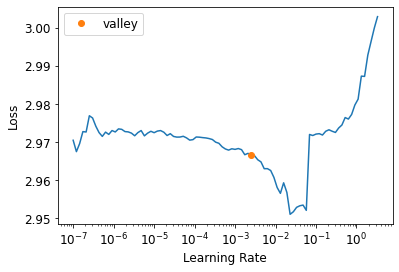

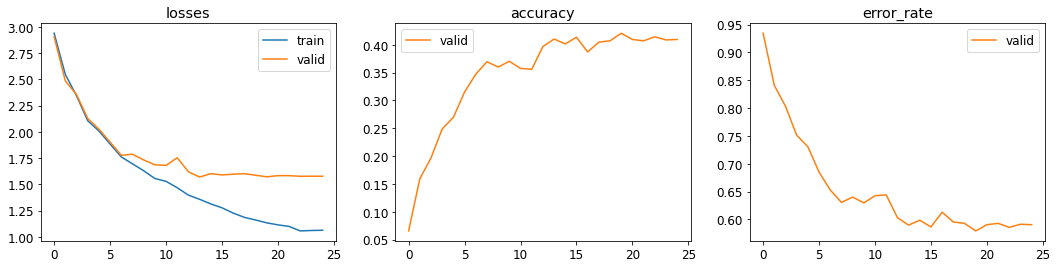

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 28 x 28    
Conv2d                                    456        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 6 x 14 x 14    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 10 x 10   
Conv2d                                    2416       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 5 x 5     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 400    

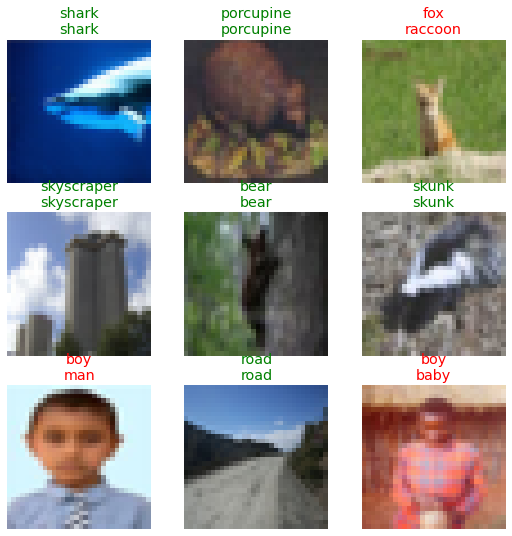

In [ ]:
from fastai.test_utils import *
dls=reducedcifardl
model=baseNet
learn = Learner(dls, model, metrics=[accuracy,error_rate], loss_func=FocalLossFlat()) # setting the learning scenario
lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(lr[0])
learn.fit_one_cycle(n_epoch=25, lr_max=lr[0]) # running the optimizer one-cycle
learn.recorder.plot_metrics() # shows accuracy curve along epochs
learn.show_results()
learn.summary() # show all details

Observamos en las gráficas el comportamiento habitual del entrenamiento en aprendizaje automático, el error de entrenamiento va disminuyendo tanto como la potencia del modelo sea capaz. Por otro lado el error de validación también va disminuyendo pero no tanto, y a partir de la época 14 se estabiliza y podemos decir que el modelo ya no esta aprendiendo, una solución para evitar esto y ahorrar tiempo sería implementar una política de early_stopping como haremos en el ejercicio 2. Podemos observar que el accuracy tiene un comportamiento muy similar, aunque algo mas oscilatorio a causa de mínimos cambios de clasificación de algunas imágenes de validación por pequeñas actualizaciones de los pesos.

Now, we want to check the performance of our trained model in testing

Para comprobar la solvencia de nuestro modelo sobre datos nuevos, utilizaremos el método test_dl para crear un objeto que cargue los datos de test, en el caso de que usaramos normalización, auomáticamente los cargaría aplicandoles la normalización con los datos de training.

In [ ]:
doc(learn.dls.test_dl)
# We create the test dataloader
test_dl = learn.dls.test_dl(files_test, with_labels=True)
# We can check that we have indeed 2500 test examples
test_dl.show

Finalmente usaremos get_preds para aplicar el clasificador aprendido sobre los nuevos datos y calcularemos el accuracy.

Se obtiene un 42 % con este modelo tan simple, que para tratarse de un problema con 25 clases no está mal, además era lo esperado por lo visto en el error de validación que puede usarse como estimación del error sobre nuevos datos.

Podemos afirmar que se está produciendo underfitting, en este caso dado que la cantidad de datos disponibles y el tiempo de entrenamiento son razonables, el motivo es que el modelo no tiene la complejidad suficiente para ajustar bien los datos (la función que buscamos no parece estar en el conjunto de hipótesis), debemos utilizar redes con más parámetros y utilizar otras técnicas para mejorarlas.

Podemos conseguir algo mejor con las técnicas del próximo ejercicio

In [ ]:
doc(learn.get_preds)
# We perform prediction on this bunch of data
preds, targs = learn.get_preds(dl=test_dl)

In [ ]:
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  42.04 %


In [ ]:
  interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
  cm = interp.confusion_matrix()
  print('Number of test examples:', np.sum(cm))
  interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')



---






# **Exercise 2:** **Improvement of the BaseNet model (3 points)**
Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. A good combination of layers can make the accuracy of the new model close to 50% on our CIFAR100 data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataLoader or ImageDataLoaders class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that test_transform uses the same normalization parameters as train_transform.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? This answer on stack-exchange (https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set/18346#18346) is a good summary of using train-val-test splits to reduce overfitting. This blog (https://elitedatascience.com/overfitting-in-machine-learning#how-to-prevent) is also a good reference for “early stopping”. Very important: keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataLoader or ImageDataLoaders class data zoom parameters, like zoom_range and/or horizontal_flip. Remember that you should not have any data augmentation in the validation or test sets. If you need a better understanding, try reading Fastai's tutorial on transformations. Look at data augmentation using image transformations.

In [ ]:
from fastai.data.external import untar_data, URLs 
from fastai.vision import *
from fastbook import *
from fastai.test_utils import *

## Normalización de datos
En primer lugar vamos a llevar a cabo la normalización de las imágenes, algo básico y utilizado en casi todos los modelos de aprendizaje automático ya sean o no redes neuronales, en específico se sabe que para las redes neuronales convolucionales es un proceso que ayuda a la optimización en el método habitual de descenso de gradiente estocástico o similares.

En nuestro caso vamos a utilizar uno de los 2 métodos más extendidos, la normalización a media 0 y varianza 1, para ello debemos calcular a priori la media y la varianza del conjunto de entrenamiento. Se ha utilizado un snippet de código bastante elegante tomado de https://towardsdatascience.com/fastai-bag-of-tricks-experiments-with-a-kaggle-dataset-part-1-135e46da72f2.

Es importante que estos datos se calculen sólo en training, y que en el momento de test se normalice según la media y varianza de training para evitar filtrado de información que puede hacer que sobreestimemos la calidad del modelo (data snooping). Esta es una política fundamental, dejar los datos que se utilicen en test vírgenes y no usarlos para nada más que eso.

In [ ]:
means = [xb.mean(dim=(0, 2, 3)) for xb, yb in reducedcifardl.train]
stds = [xb.std(dim=(0, 2, 3)) for xb, yb in reducedcifardl.train]
mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
print(mean, std)

TensorImage([0.4689, 0.4604, 0.4275], device='cuda:0') TensorImage([0.2582, 0.2460, 0.2617], device='cuda:0')


La librería fastai y sus datablocks y learners realizan la normalización de esta forma correcta automáticamente si usamos el método normalize_from_stats ylos objetos y métodos de test: testdl y getpreds

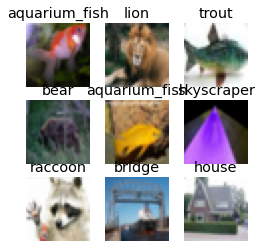

In [ ]:
reducedcifar = DataBlock(blocks    = (ImageBlock, CategoryBlock), 
                   get_items = get_image_files, 
                   get_y     = parent_label, 
                   splitter  = RandomSplitter(valid_pct=0.1, seed=2022),
                   batch_tfms= [Normalize.from_stats(mean, std)]) #Normalizamos en función de las medias y varianzas obtenidas
reducedcifardl1 = reducedcifar.dataloaders(path/'train')
reducedcifardl1.show_batch(max_n=9, figsize=(4,4))

Creamos el mismo modelo baseNet en una nueva variable, esto es necesario para reiniciar los pesos porque sino empezaríamos con los entrenados anteriormente. Todo el proceso a continuación es idéntico al ejercicio 1, salvo que se utilizará el dataloader que tiene la normalización aplicada.

In [ ]:
baseNetNormalized=nn.Sequential(
    nn.Conv2d(3, 6, 5, 1), nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5, 1), nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(), nn.Linear(400, 50), nn.ReLU(),
    nn.Linear(50, 25)
)
total_params(baseNet)

(24197, True)

0.001737800776027143


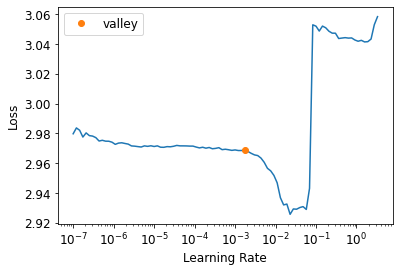

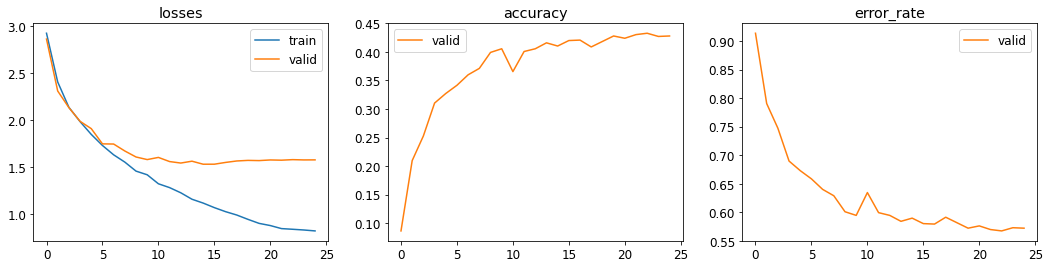

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 28 x 28    
Conv2d                                    456        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 6 x 14 x 14    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 10 x 10   
Conv2d                                    2416       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 5 x 5     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 400    

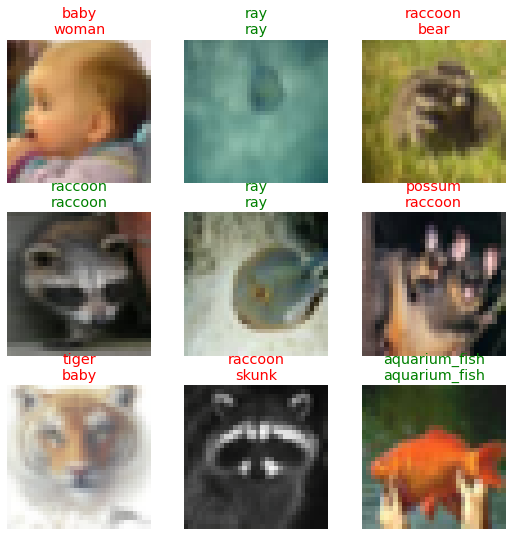

In [ ]:
dls=reducedcifardl1
model=baseNetNormalized
learn = Learner(dls, model, metrics=[accuracy,error_rate], loss_func=FocalLossFlat()) # setting the learning scenario
lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(lr[0])
learn.fit_one_cycle(n_epoch=25, lr_max=lr[0]) # running the optimizer one-cycle
learn.recorder.plot_metrics() # shows accuracy curve along epochs
learn.show_results()
learn.summary() # show all details

En este caso observamos un comportamiento similar en las gráficas, aunque si nos fijamos, el algoritmo ha conseguido ajustar algo mejor los datos de entrenamiento, el train_loss final desciende desde 1.06 a 0.82, esto puede deberse a la normalización. Sin embargo el error y accuracy de validación son casi iguales, por tanto en este caso tenemos un error de generalización myor.

El error de test lo refleja, descendiendo ligeramente a 41,68 %. Hemos conseguido que el modelo llegue a unos resultados similares a la versión sin normalizar en cuanto a accuracy, en un par de épocas menos, este es otro efecto que ha tenido la normalización.

In [ ]:
test_dl = learn.dls.test_dl(files_test, with_labels=True)
preds, targs = learn.get_preds(dl=test_dl)
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  41.68 %


## Método de entrenamiento y Early Stopping
En este apartado voy a definir una función que llamaremos para realizar los entrenamientos con las distintas arquitecturas y mejoras introducidas. Además aprovecharé para definir la política de Early Stopping que se seguirá en los próximos experimentos. En este caso utilizaré como criterio a monitorizar el accuracy en validación pues es la más cercana a lo que se quiere conseguir, un modelo que acierte lo máximo posible en los datos nuevos. En principio utilizaré 3 épocas como "paciencia" para que el modelo vuelva a mejorar, esto se ha obtenido mediante prueba de los modelos una pocas épocas y observación de como oscilan los valores. Curiosamente al utilizar data augmentation puede ser necesario aumentarlo un poco, se explicará posteriormente.

El Early Stopping es un método para evitar el sobreentrenamiento, el punto donde una red neuronal empieza a obtener peores resultados en validación o a no mejorar, algo clásico en las gráficas con las que se explica el overfitting, actua también en cierto modo como regularización. Vamos a implementarlo en todos los modelos a partir de ahora pues su objetivo es beneficioso, minimizar el error de generalización. Para implementarlo, fastai utiliza su sistema de callbacks, basta incluirlo en la construcción del Learner.

In [ ]:
def train_validate(data, network, earlystop_patience):
  dls=data
  model=network
  learn = Learner(dls, model, metrics=[accuracy,error_rate], loss_func=FocalLossFlat(), cbs=EarlyStoppingCallback(monitor='accuracy', patience=earlystop_patience)) # setting the learning scenario
  lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
  print(lr[0])
  learn.fit_one_cycle(n_epoch=25, lr_max=lr[0]) # running the optimizer one-cycle
  learn.recorder.plot_metrics() # shows accuracy curve along epochs
  learn.show_results()
  learn.summary() # show all details
  return learn 

También aprovechamos para definir una función que realize el test y un informe con la matriz de confusión en el conjunto de test.

In [ ]:
def test_model(learn):
  test_dl = learn.dls.test_dl(files_test, with_labels=True)
  preds, targs = learn.get_preds(dl=test_dl)
  acc = accuracy(preds, targs)
  print('The test accuracy is : ', round(float(acc)*100, 4), '%')
  interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
  cm = interp.confusion_matrix()
  print('Number of test examples:', np.sum(cm))
  interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')

## Dropout y Batch Normalization

En esta sección vamos a añadir a nuestro modelo estas dos técnicas que mejoran la optimización y regularizan en cierto modo el modelo:

Batch Normalization es una técnica que mejora el entrenamiento y la estabilidad de las redes neuronales, se basa en normalizar las entradas a las capas ocultas en cada mini-batch, además se aplica un escalado y translación a los datos, los parámetros de esta transformación se aprenden como parámetros de la red, esto otorga al modelo cierta robustez frente a pequeños zoom y translaciones.

Dropout es un método sencillo para acelerar el entrenamiento y regularizar. Simplemente se elimina de forma aleatoria con probabilidad p cada neurona de las capas ocultas, de este modo forzamos a las neuronas a generalizar y a no depender tanto de neuronas específicas, sino que la red entera consiga captar la tendencia general. Suele usarse en las capas totalmente conectadas, excepto en la última, la más cercana al softmax, aunque también se han obtenido buenos resultados en las capas convolucionales con probabilidad de apagado de neurona más baja.

Vamos a probar distintos valores del parámetro de Dropout en la arquitectura anterior, ademñas añadiremos BatchNormalization después de las convoluciones, la interpretación de los resultados con Dropout es difusa, porque las neuronas se desactivan sólo en entrenamiento, por tanto en test el modelo puede interpretarse como la media de un ensemble de todas las posibles redes existentes resultado de los distintos apagados de neuronas:

Parámetro de Dropout: 0


0.0030199517495930195


No improvement since epoch 9: early stopping


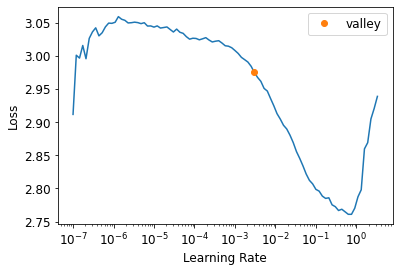

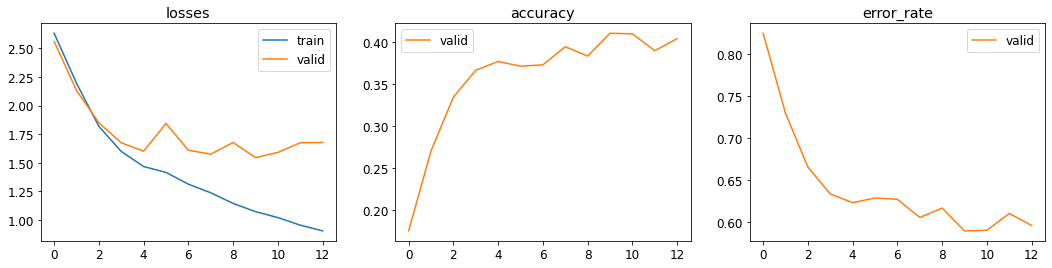

The test accuracy is :  42.0 %


Number of test examples: 2500


Test Accuracy
42.0
Parámetro de Dropout: 0.1


0.00363078061491251


No improvement since epoch 10: early stopping


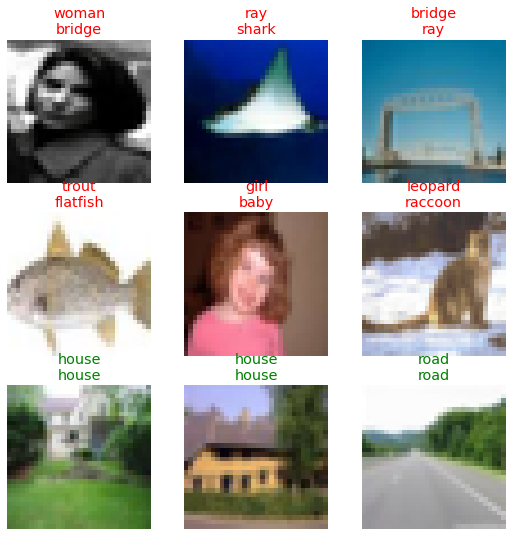

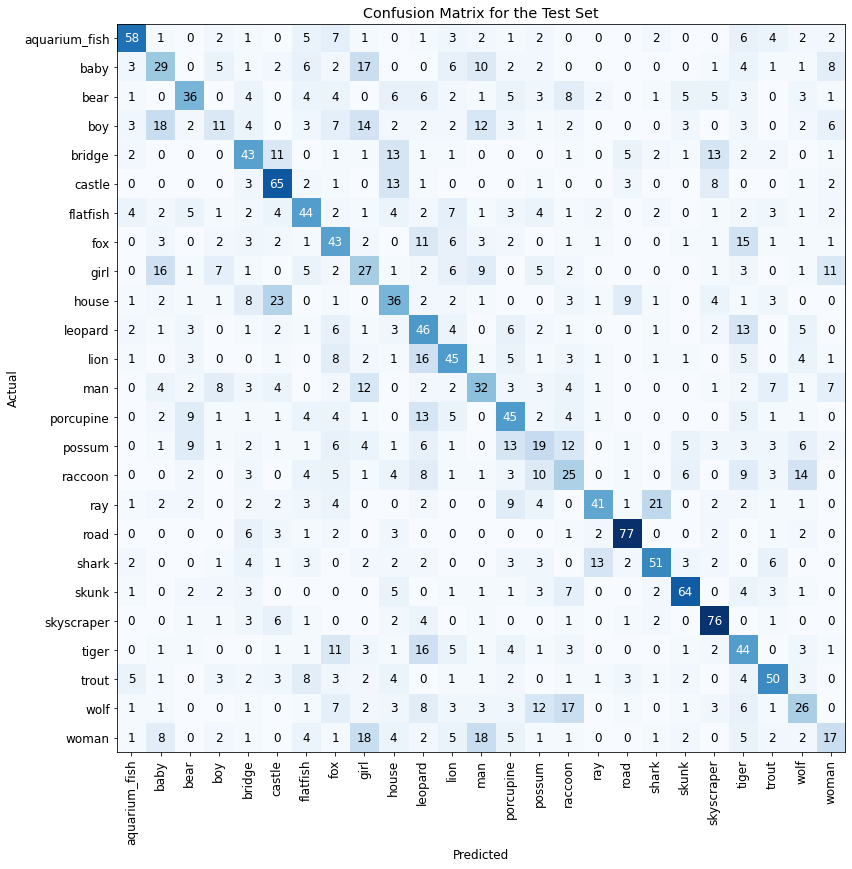

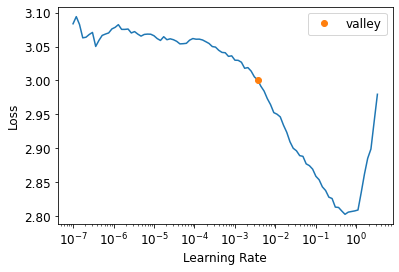

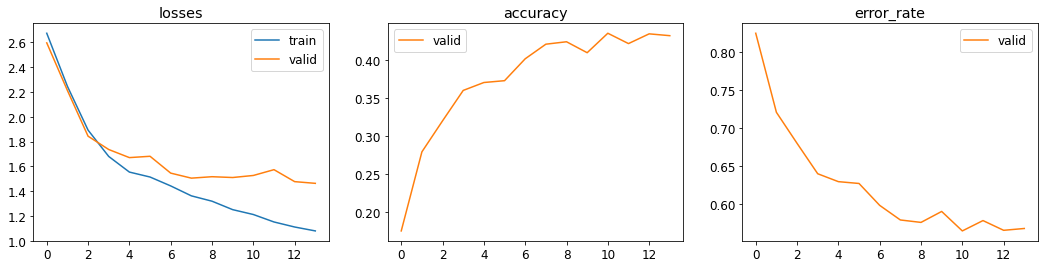

The test accuracy is :  42.92 %


Number of test examples: 2500


Test Accuracy
42.92
Parámetro de Dropout: 0.25


0.010964781977236271


No improvement since epoch 6: early stopping


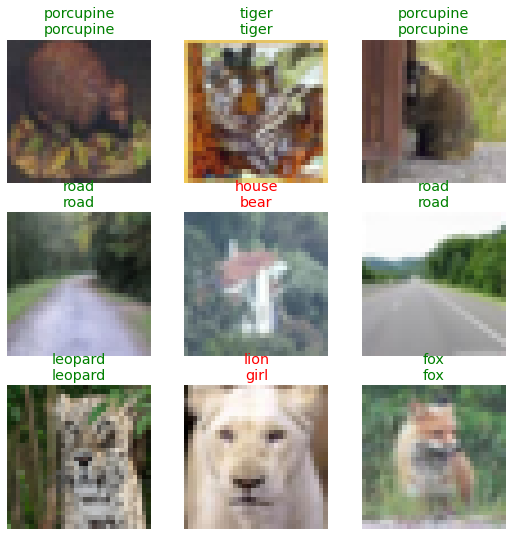

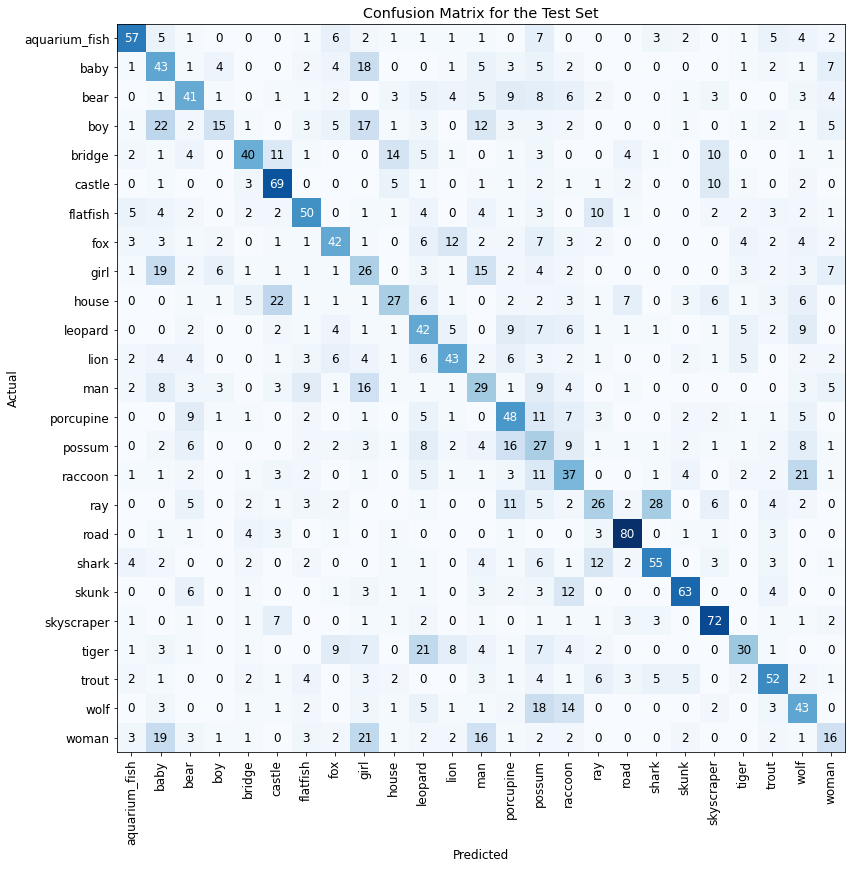

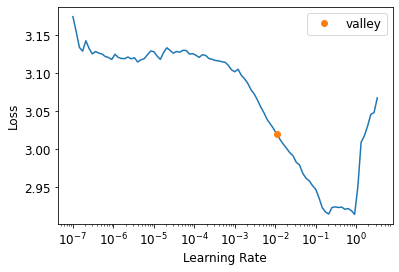

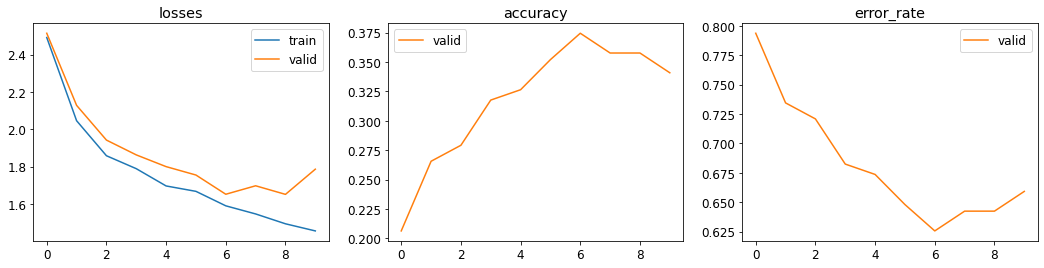

The test accuracy is :  33.08 %


Number of test examples: 2500


Test Accuracy
33.08
Parámetro de Dropout: 0.5


0.009120108559727669


No improvement since epoch 5: early stopping


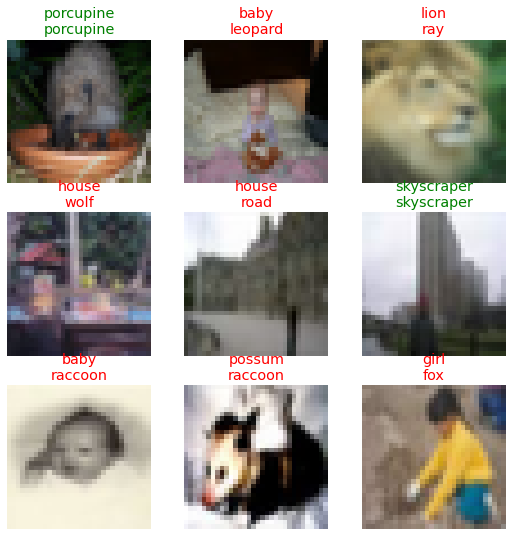

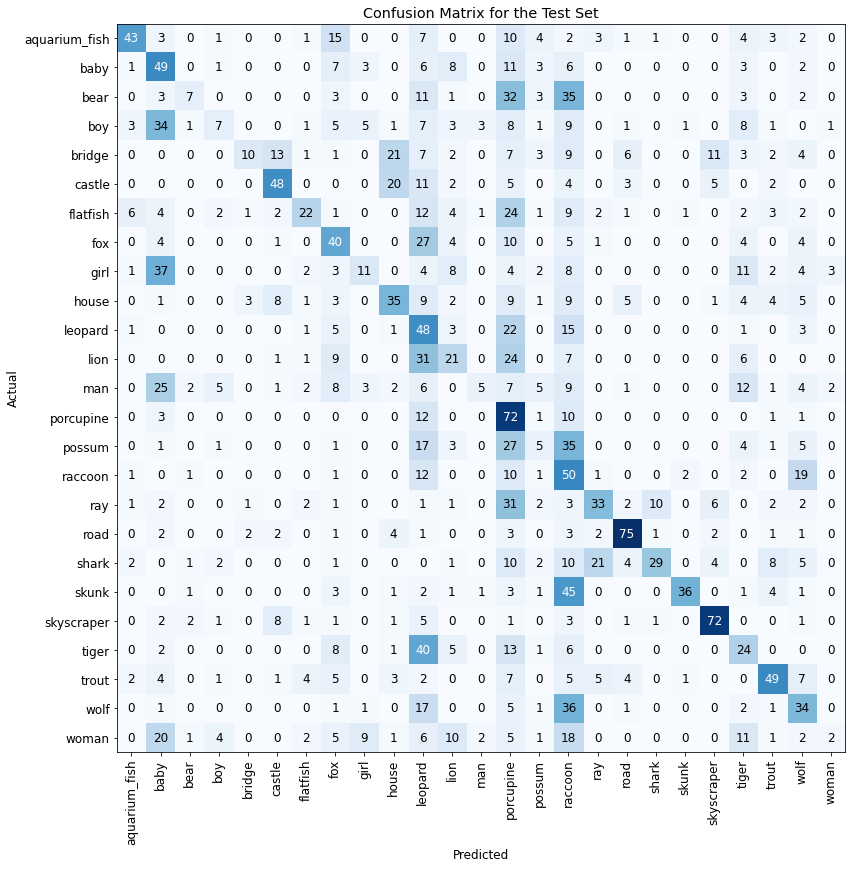

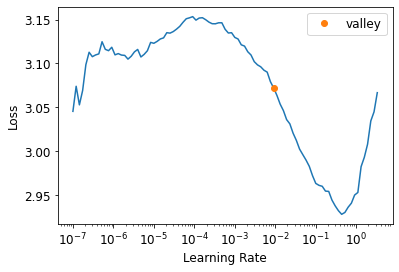

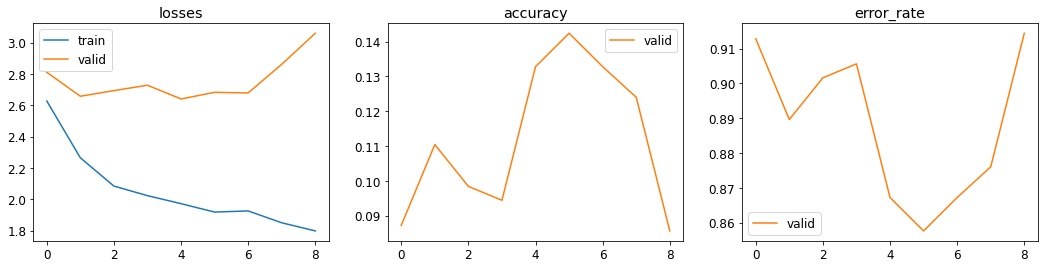

The test accuracy is :  8.2 %


Number of test examples: 2500


Test Accuracy
8.200000000000001


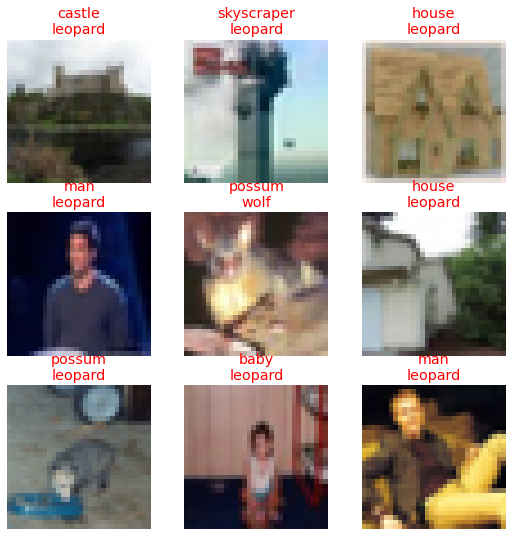

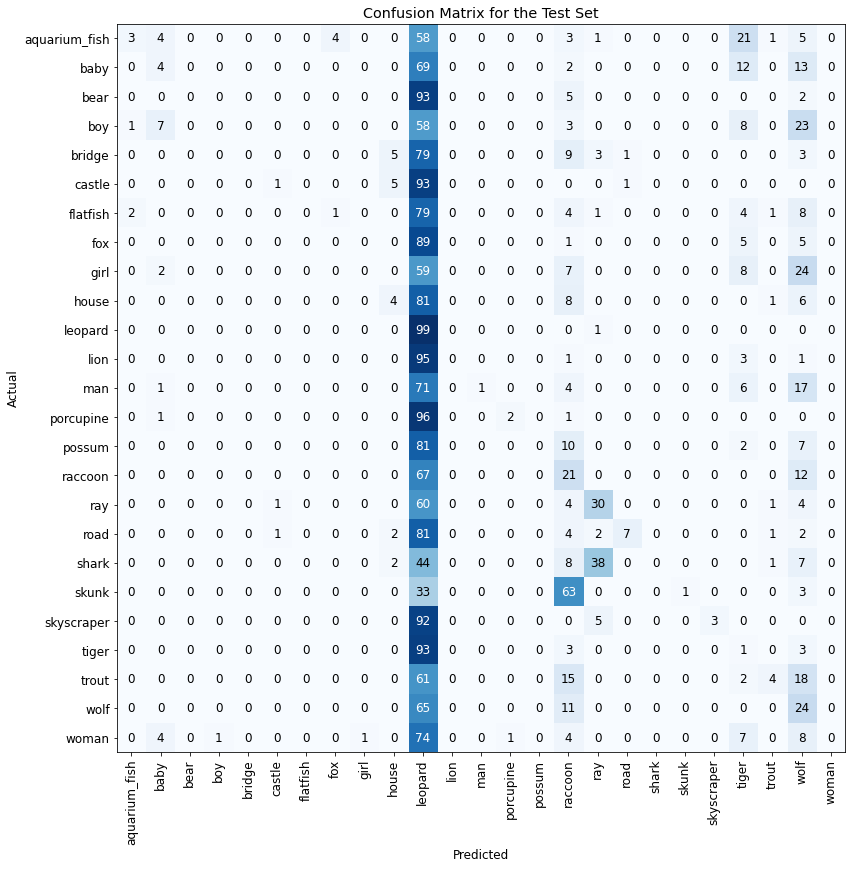

In [ ]:
def dropoutParamChoosing(probs):
  for prob in probs:
    print("Parámetro de Dropout: "+str(prob))
    baseNetDropBatchNorm1=nn.Sequential(
        nn.Conv2d(3, 6, 5, 1), 
        nn.BatchNorm2d(6),
        nn.Dropout(p=prob, inplace=False),
        nn.ReLU(), 
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5, 1),
        nn.BatchNorm2d(16),
        nn.Dropout(p=prob, inplace=False),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(), nn.Linear(400, 50), nn.BatchNorm1d(50), nn.Dropout(p=prob, inplace=False), nn.ReLU(),
        nn.Linear(50, 25)
    )
    test_model(train_validate(reducedcifardl1, baseNetDropBatchNorm1, 3))

dropoutParamChoosing([0, 0.1, 0.25, 0.5])



En la siguiente red se tratará de modificar los parámetros del dropout para hacerlo mayor en las capas totalmente conectadas como aconseja el paper original, para ello usaremos el dropout mejor obtenido en las capas convolucionales, 0.1 y en la capa totalmente conectada, el siguiente mejor, 0.25.

0.007585775572806597


No improvement since epoch 17: early stopping


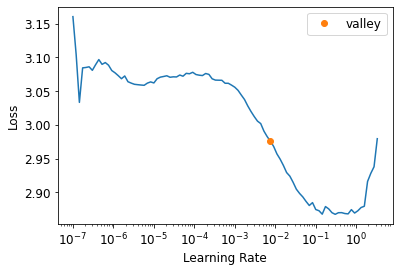

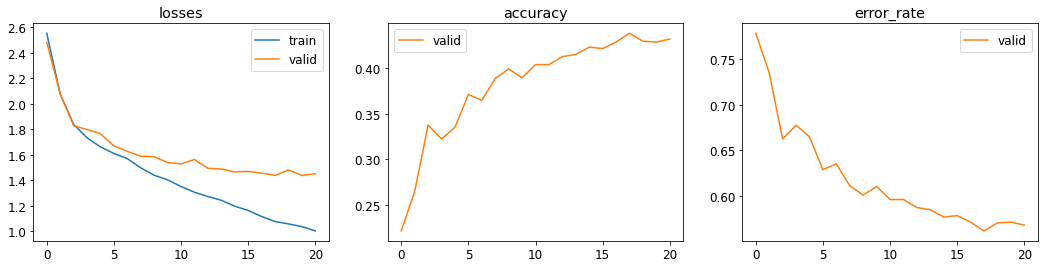

The test accuracy is :  44.52 %


Number of test examples: 2500


Test Accuracy
44.519999999999996


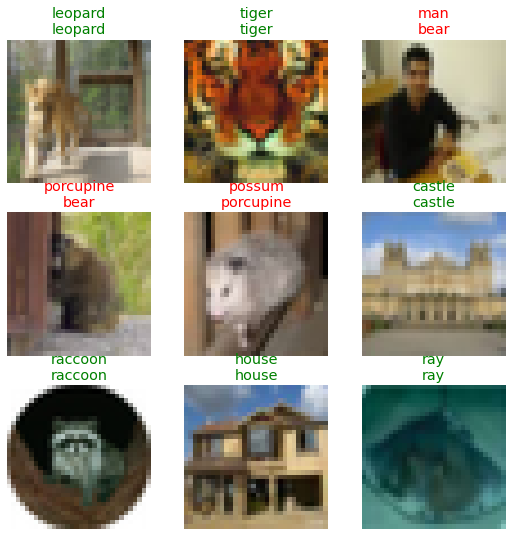

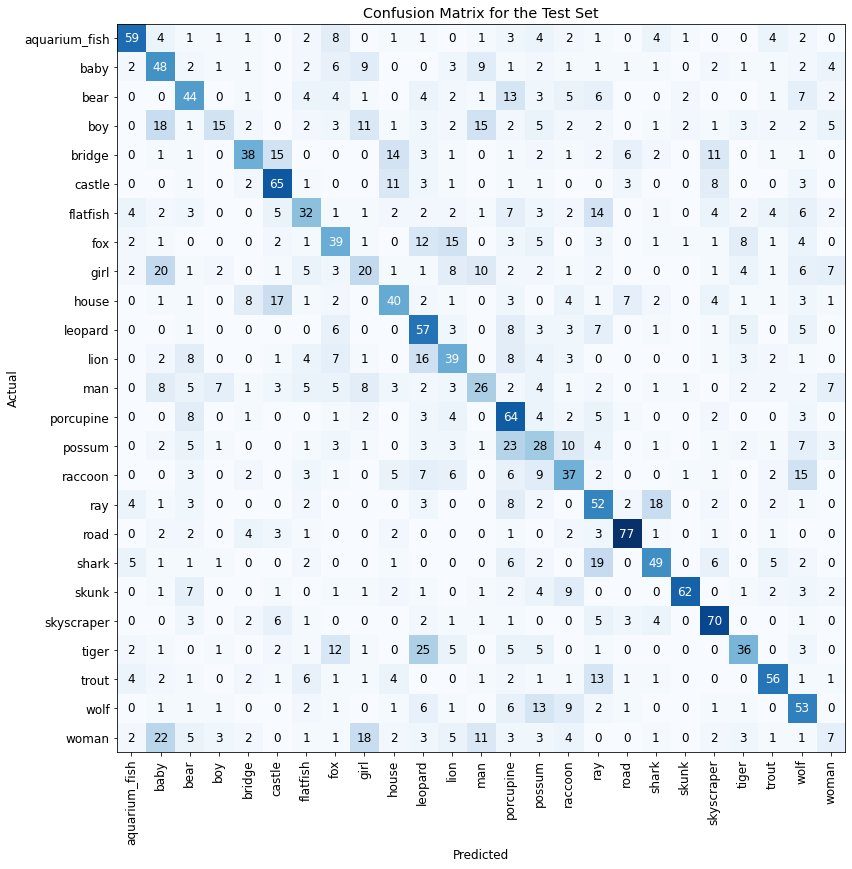

In [ ]:
baseNetDropBatchNorm1=nn.Sequential(
    nn.Conv2d(3, 6, 5, 1), 
    nn.BatchNorm2d(6),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5, 1),
    nn.BatchNorm2d(16),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(), nn.Linear(400, 50), nn.BatchNorm1d(50), nn.Dropout(p=0.25, inplace=False), nn.ReLU(),
    nn.Linear(50, 25)
)
test_model(train_validate(reducedcifardl1, baseNetDropBatchNorm1, 3))

Hasta ahora habíamos probado a utilizar la Batch Normalization antes de la activación ReLU, aunque existen discusiones proponiendo lo contrario, como este artículo, https://blog.paperspace.com/busting-the-myths-about-batch-normalization/.

Aquí se expone que es mejor realizarla después debido a que así controlamos mejor el input que le entrará a la siguiente capa de neuronas, si lo hacemos antes, la activación hará cambios que no mantendrán la normalización.

Vamos a probar que ocurre en nuestro problema:

0.005248074419796467


No improvement since epoch 8: early stopping


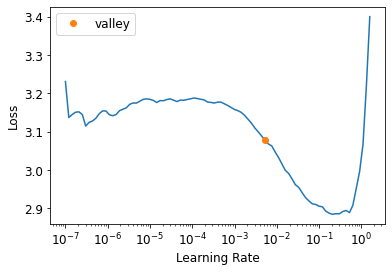

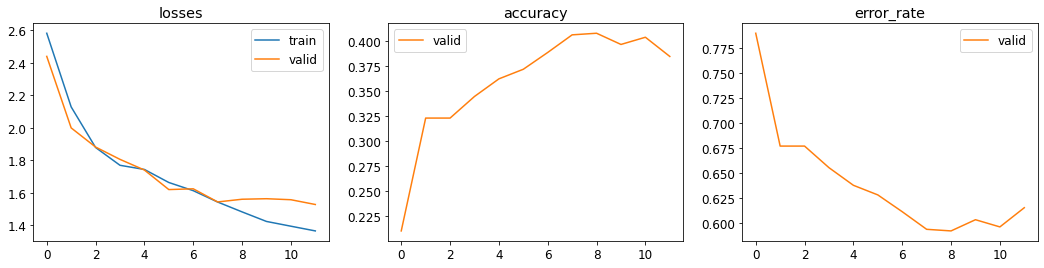

The test accuracy is :  39.76 %


Number of test examples: 2500


Test Accuracy
39.76


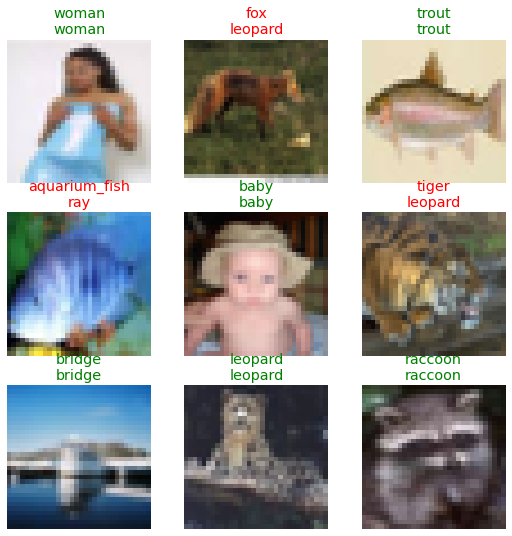

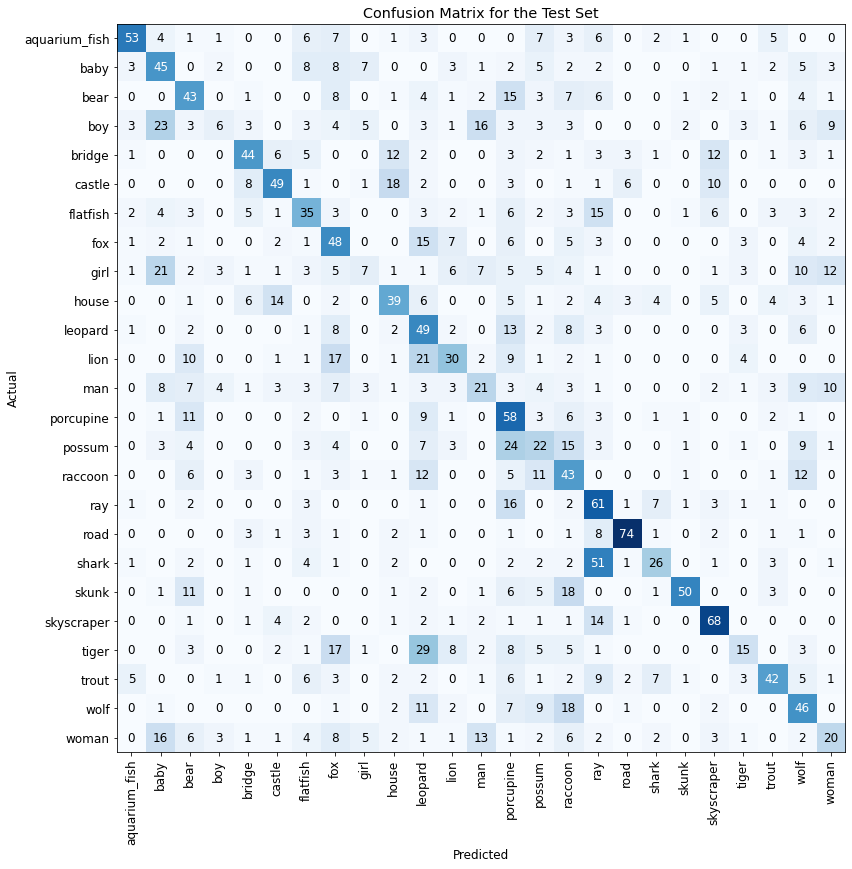

In [ ]:
baseNetDropBatchNorm2=nn.Sequential(
    nn.Conv2d(3, 6, 5, 1), 
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(), 
    nn.BatchNorm2d(6),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5, 1),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2),
    nn.Flatten(), nn.Linear(400, 50), nn.Dropout(p=0.25, inplace=False), nn.ReLU(), nn.BatchNorm1d(50), 
    nn.Linear(50, 25)
)
test_model(train_validate(reducedcifardl1, baseNetDropBatchNorm2, 3))

## Arquitecturas más profundas y distintos tamaños de convolución

En primer lugar, vamos a probar a mantener la profundidad de la red, pero a aumentar el número de canales, es decir, el número de mapas de características que se obtienen, esto aumentará la complejidad del modelo y por tanto su capacidad para ajustar y modelar mejor los datos.

0.0005754399462603033


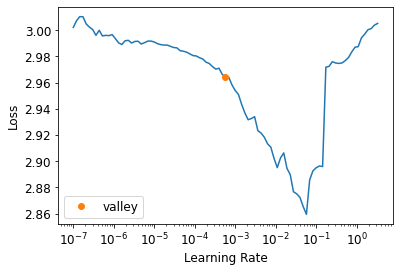

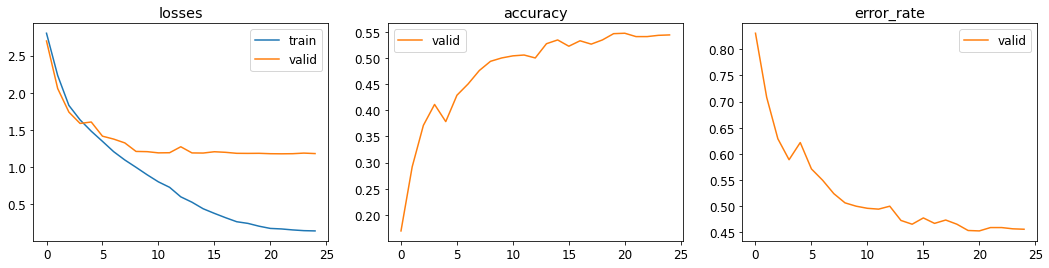

The test accuracy is :  54.36 %


Number of test examples: 2500


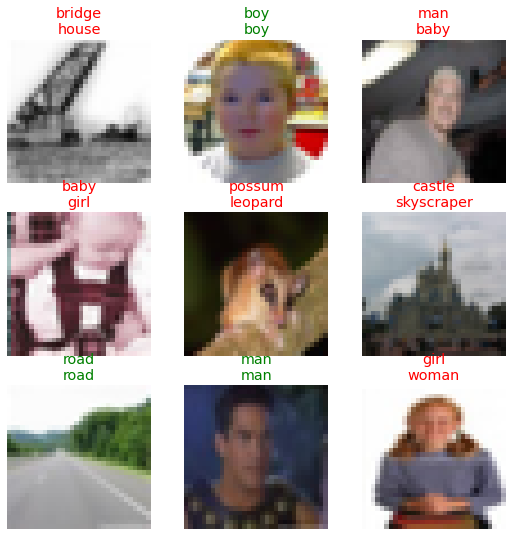

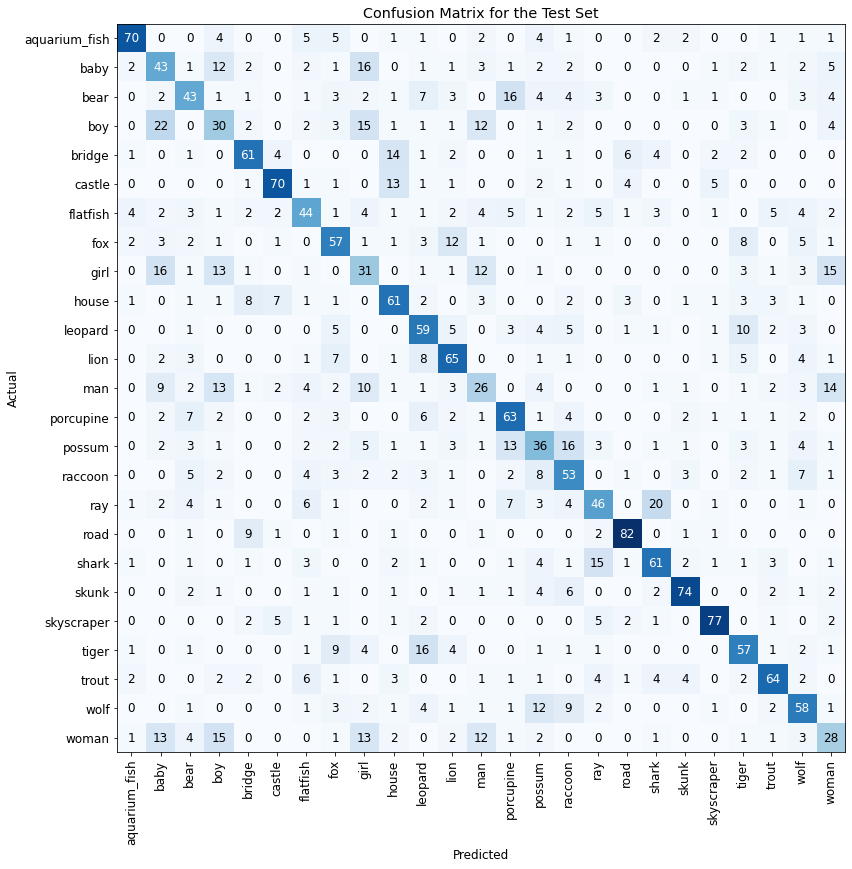

In [ ]:
baseNet1=nn.Sequential(
    nn.Conv2d(3, 32, 5, 1), 
    nn.BatchNorm2d(32),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 5, 1),
    nn.BatchNorm2d(64),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(), 
    nn.Linear(1600, 400), nn.Dropout(p=0.1, inplace=False), nn.ReLU(), 
    nn.Linear(400, 50), nn.Dropout(p=0.1, inplace=False), nn.ReLU(),
    nn.Linear(50, 25)
)
test_model(train_validate(reducedcifardl1, baseNet1, 5))

En este caso vamos a aumentar la profundidad, aunque también los canales. Los primeros dos bloques de convoluciones serán de tamaño 5x5 y el último de tamaño 3x3, sólo colocamos Pooling en el primer bloque. Esto genera muchos valores de salida, luego añadiremos también otra capa totalmente conectada.

Exception ignored in: <finalize object at 0x7f8e05b18870; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 936, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'models/tmp7guw9mht'


0.0006918309954926372


Exception ignored in: <finalize object at 0x7f8e05b18870; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 936, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: Exception ignored in: [Errno 2] No such file or directory: 'models/tmp7guw9mht'
<finalize object at 0x7f8e05b18870; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 936, in _cleanup
    _rmtree(name)
onerror(os.lstat, path, sys.exc_info())  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    
  File "/usr/lib/python3.7/shutil

No improvement since epoch 13: early stopping


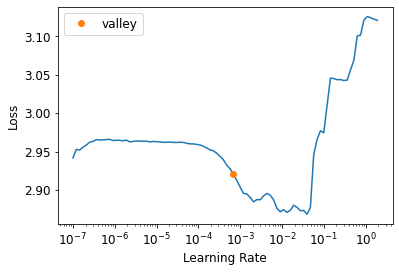

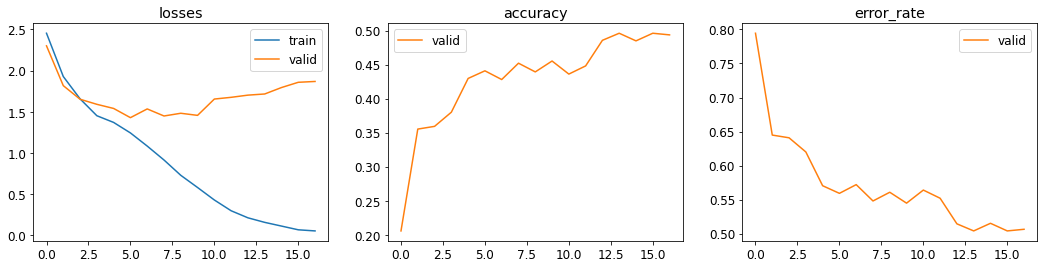

The test accuracy is :  49.0 %


Number of test examples: 2500


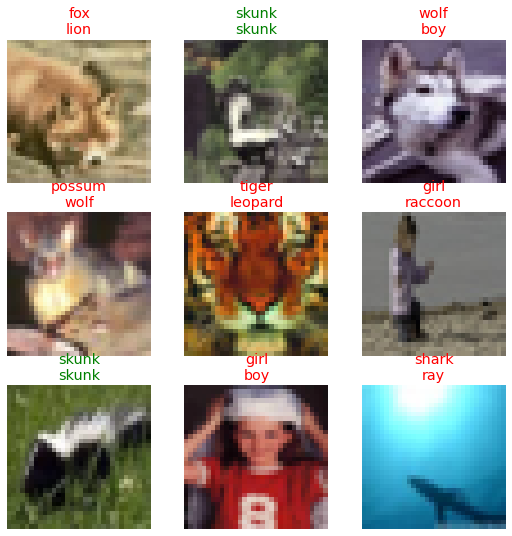

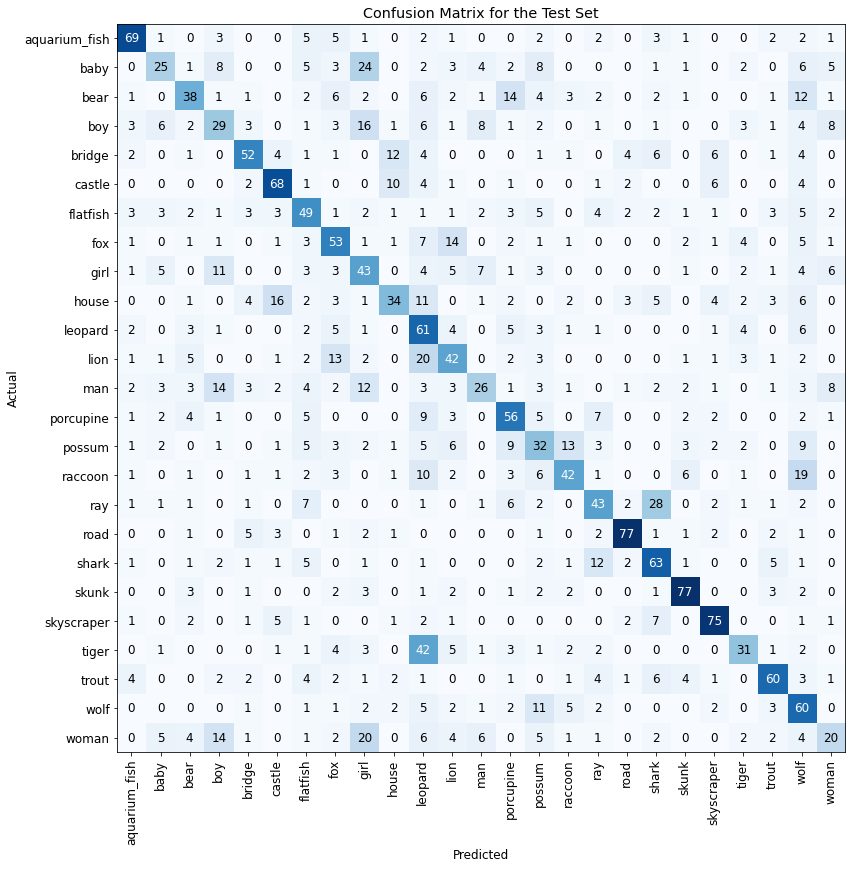

In [ ]:
baseNetDeeper=nn.Sequential(
    nn.Conv2d(3, 16, 5, 1), 
    nn.BatchNorm2d(16),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 5, 1), 
    nn.BatchNorm2d(32),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(), 
    nn.Conv2d(32, 64, 3, 1),
    nn.BatchNorm2d(64),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.Flatten(), 
    nn.Linear(4096, 1024), nn.Dropout(p=0.1, inplace=False), nn.ReLU(), 
    nn.Linear(1024, 256), nn.Dropout(p=0.1, inplace=False), nn.ReLU(),
    nn.Linear(256, 25),
)
total_params(baseNetDeeper)
test_model(train_validate(reducedcifardl1, baseNetDeeper, 3))

En la siguiente red colocamos un primer bloque de convoluciones 5x5 con Pooling y despues 2 bloques de 3x3 con Pooling sólo despues de la segunda. Esto reduce el número de entradas a la capa totalmente conectada, disminuyendo así los parámetros.

0.0014454397605732083


No improvement since epoch 12: early stopping


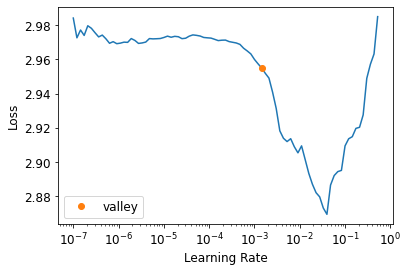

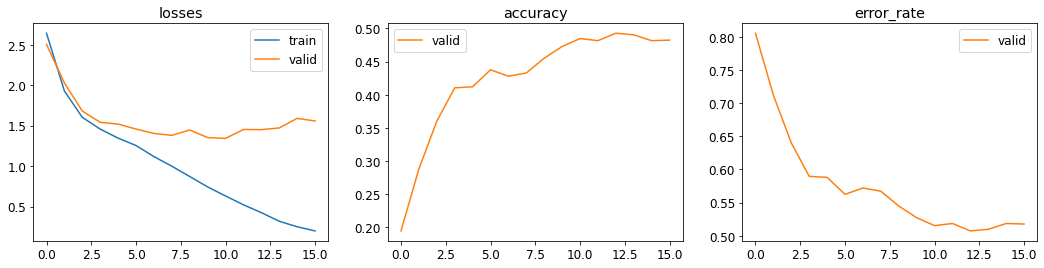

KeyError: ignored

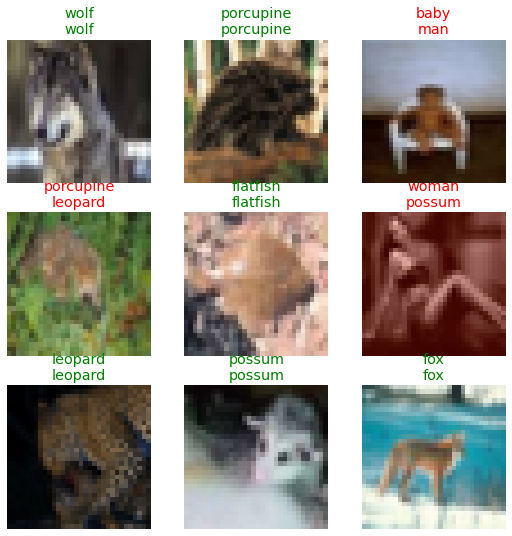

In [ ]:
baseNetDeeper2=nn.Sequential(
    nn.Conv2d(3, 16, 5, 1), 
    nn.BatchNorm2d(16),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, 1), 
    nn.BatchNorm2d(32),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, 1),
    nn.BatchNorm2d(64),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.Flatten(), 
    nn.Linear(1024, 256), nn.ReLU(), 
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 25)
)
total_params(baseNetDeeper2)
test_model(train_validate(reducedcifardl1, baseNetDeeper2, 3))

OTRA

---



---



---

0.0010000000474974513


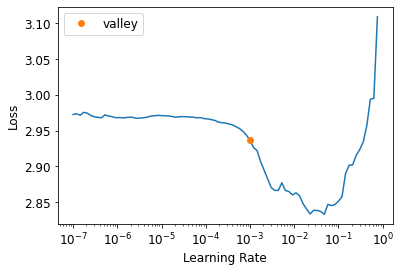

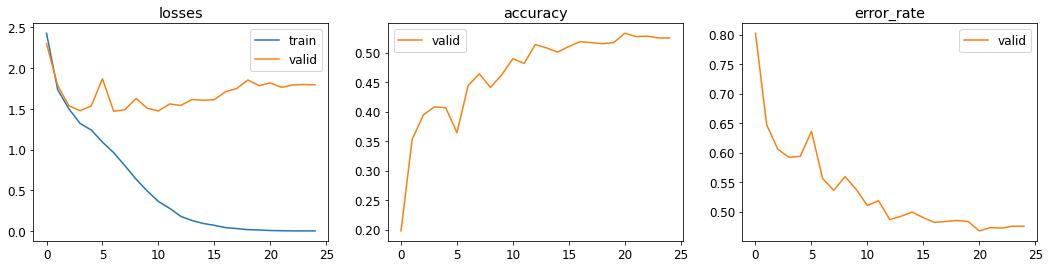

The test accuracy is :  53.92 %


Number of test examples: 2500


Test Accuracy
53.92


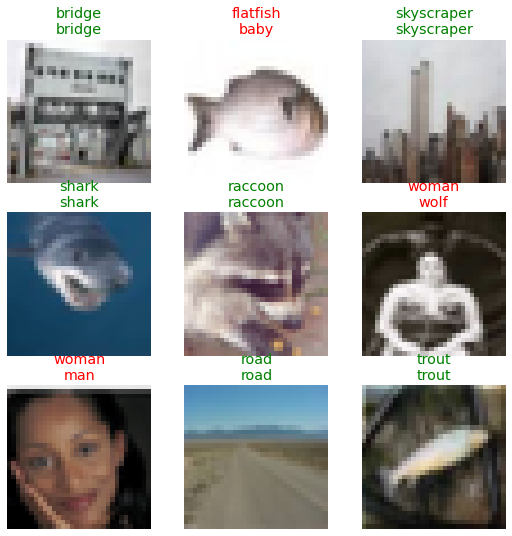

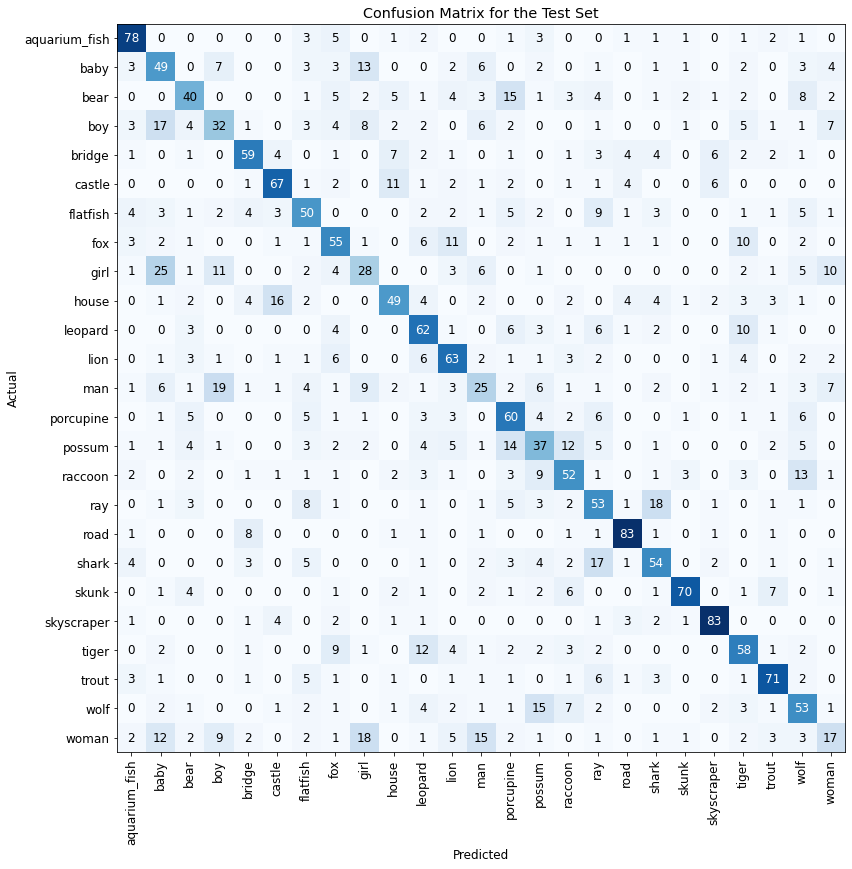

In [ ]:
baseNetDeeper2=nn.Sequential(
    nn.Conv2d(3, 32, 5, 1), 
    nn.Dropout(p=0.1, inplace=False),
    nn.BatchNorm2d(32),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, 1), 
    nn.Dropout(p=0.1, inplace=False),
    nn.BatchNorm2d(64),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, 1),
    nn.BatchNorm2d(128),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.Flatten(), 
    nn.Linear(2048, 512), nn.ReLU(), 
    nn.Linear(512, 128), nn.ReLU(),
    nn.Linear(128, 25)
)
total_params(baseNetDeeper2)
test_model(train_validate(reducedcifardl1, baseNetDeeper2, 5))

OTRA MAS

0.00019054606673307717


No improvement since epoch 21: early stopping


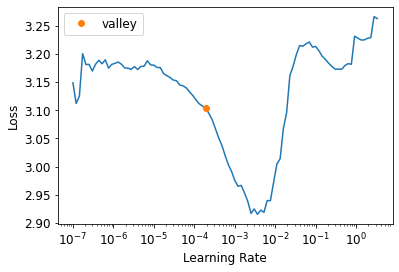

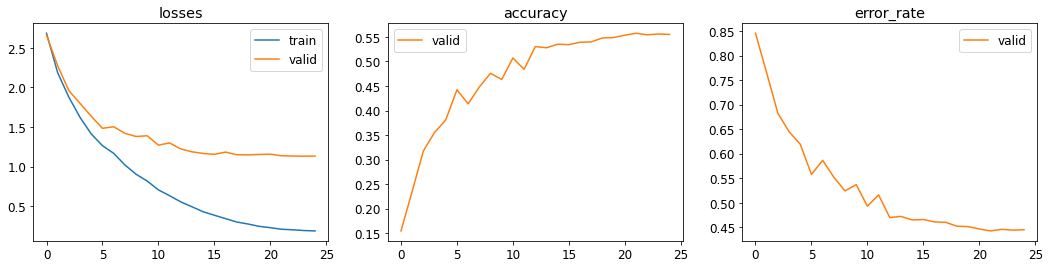

The test accuracy is :  54.08 %


Number of test examples: 2500


Test Accuracy
54.08


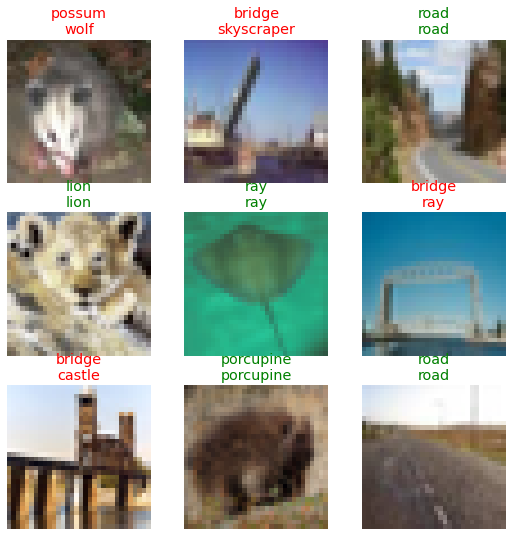

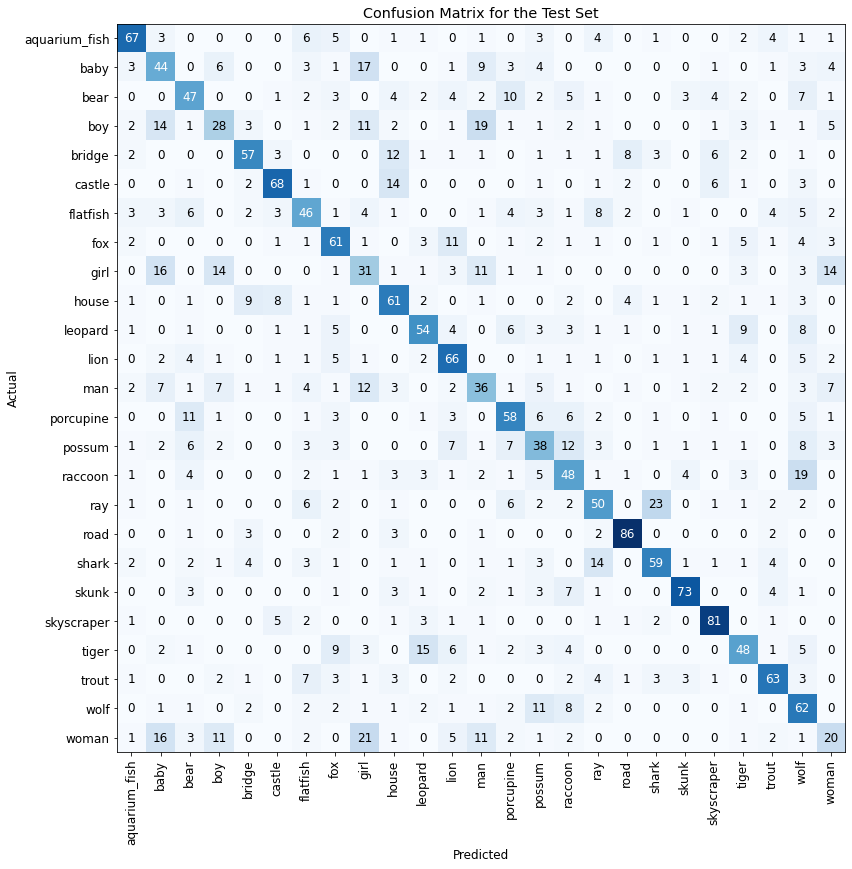

In [ ]:
baseNetDeeper=nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, padding='same'), 
    nn.Dropout(p=0.1, inplace=False),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, 1, padding='same'),
    nn.Dropout(p=0.1, inplace=False),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 5, 1, padding='same'), 
    nn.Dropout(p=0.1, inplace=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 5, 1, padding='same'),
    nn.BatchNorm2d(64),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(), 
    nn.Linear(4096, 25)
)
total_params(baseNetDeeper)
test_model(train_validate(reducedcifardl1, baseNetDeeper, 3))

## Data Augmentation

Setting-up type transforms pipelines
Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/raccoon/raccoon_s_000017.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/raccoon/raccoon_s_000017.png
    applying parent_label gives
      raccoon
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(15)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(15))


Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None,

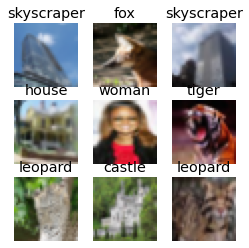

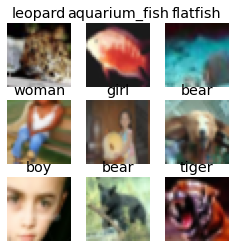

In [ ]:
reducedcifar = DataBlock(blocks    = (ImageBlock, CategoryBlock), # define the type of data block
                   get_items = get_image_files, # read all images in subfolders
                   get_y     = parent_label, # create the labels
                   splitter  = RandomSplitter(valid_pct=0.1, seed=2022),
                   batch_tfms= [*aug_transforms(), Normalize.from_stats(mean, std)]) #split the block for training and test/validation) # resize all images to the same size
reducedcifardl2 = reducedcifar.dataloaders(path/'train') # dowload tha dataset and use the DataBlock definition to create the training dataset
reducedcifardl2.show_batch(max_n=9, figsize=(4,4)) # shows a batch of images
reducedcifar.summary(path/'train')
reducedcifar = DataBlock(blocks    = (ImageBlock, CategoryBlock), # define the type of data block
                   get_items = get_image_files, # read all images in subfolders
                   get_y     = parent_label, # create the labels
                   splitter  = RandomSplitter(valid_pct=0.1, seed=2022),
                   batch_tfms= [*aug_transforms(max_rotate = 20,  min_zoom = 1,  max_zoom = 1.3, max_lighting = 0.2,), Normalize.from_stats(mean, std)]) #split the block for training and test/validation) # resize all images to the same size
reducedcifardl3 = reducedcifar.dataloaders(path/'train') # dowload tha dataset and use the DataBlock definition to create the training dataset
reducedcifardl3.show_batch(max_n=9, figsize=(4,4)) # shows a batch of images
reducedcifar.summary(path/'train')

0.0008317637839354575


No improvement since epoch 20: early stopping


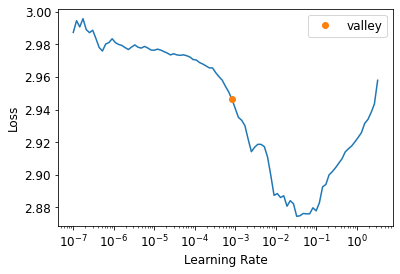

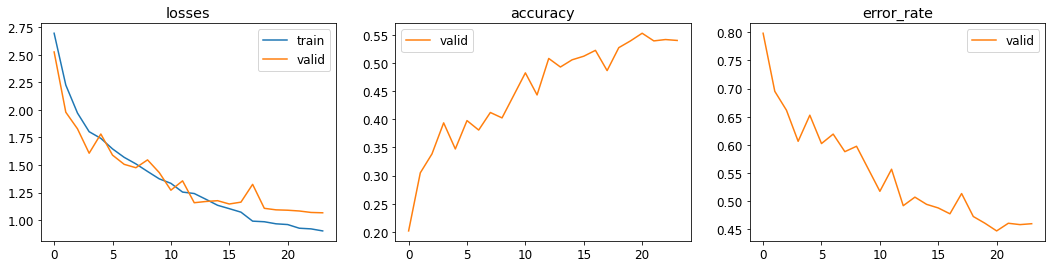

The test accuracy is :  54.24 %


Number of test examples: 2500


Test Accuracy
54.24


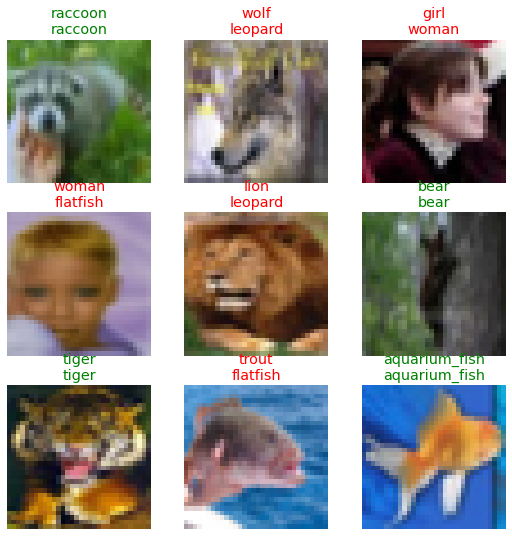

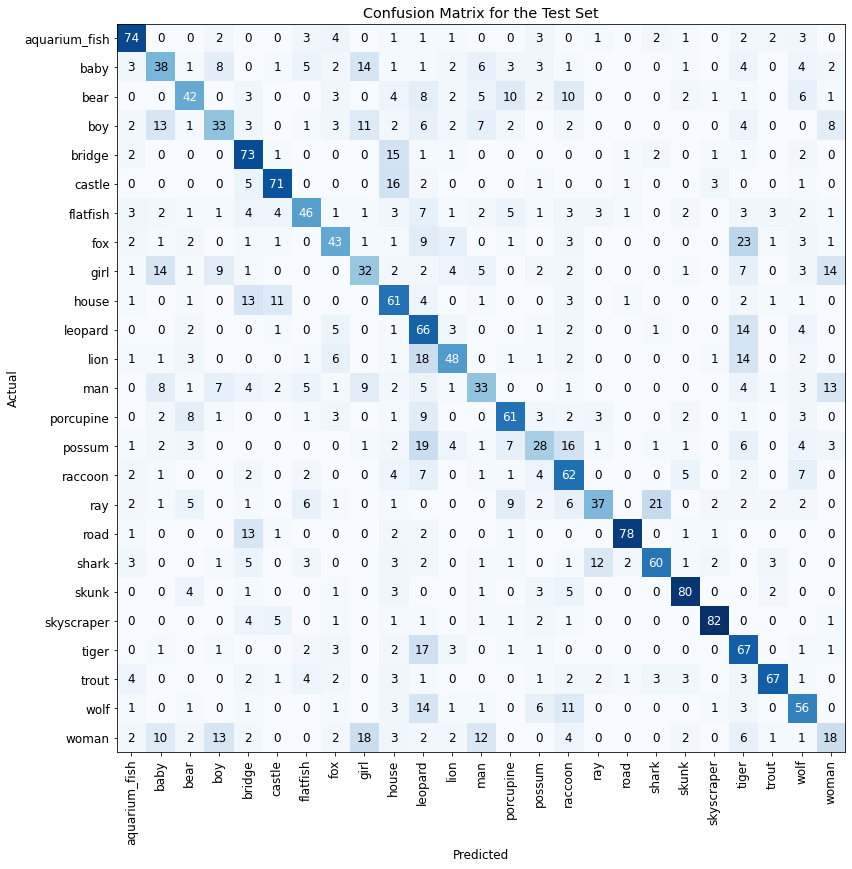

In [ ]:
baseNet1=nn.Sequential(
    nn.Conv2d(3, 32, 5, 1), 
    nn.Dropout(p=0.1, inplace=False),
    nn.BatchNorm2d(32),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 5, 1),
    nn.BatchNorm2d(64),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(), 
    nn.Linear(1600, 400), nn.Dropout(p=0.1, inplace=False), nn.ReLU(), 
    nn.Linear(400, 50), nn.Dropout(p=0.1, inplace=False), nn.ReLU(),
    nn.Linear(50, 25)
)
test_model(train_validate(reducedcifardl2, baseNet1, 3))

# **Exercise  3: Model transfer and fine-tuning with ResNet18 for the Caltech-UCSD Birds-200-2011 database (3 points)**
In this exercise we will work with the Caltech-UCSD Birds-200-2011 dataset (https://www.vision.caltech.edu/datasets/cub_200_2011/). This dataset consists of 11,788 images of 200 bird species. It has 200 classes, with 5,994 for training and 5,794 for testing. Again, 10% of the training set will be left for validation. Read the dataset using the provided functions.

We will use the ResNet18 network model already pre-trained with ImageNet, it can be downloaded from the Fastai Model repository. You have to:
1. **Use ResNet18 as a feature extractor** for the Caltech-UCSD Birds-200-2011 dataset. To do this we will remove at least the head of the downloaded model, we will add some additional convolutional blocks and a new head. Specifically, students have to perform the following experiments:
    
    **1.1.** Download and adapt the ResNet18 model trained with ImageNet to the Caltech-UCSD dataset, retrain this new fully connected layer, and estimate the network performance. 
    
    **1.2.** Remove the head of the model and add new convolutional blocks and a new head designed by you. Retrain your model with Caltech-UCSD. 
    
    **1.3.** Compare the results obtained in 1.2 and 1.1.

  Remember that, during training, you have to freeze the weights in the feature extraction blocks.

2. **Make a fine-tuning of the entire ResNet18 network** for  Caltech-UCSD. Remember that the number of epochs for fine-tuning must be small.





In [ ]:
# https://docs.fast.ai/data.external.html
path = untar_data(URLs.CUB_200_2011)

In [ ]:
# We explore a little bit the folders and number of examples.
# train_test_split.txt contains the information about which images are for training and which ones are for testing
print(path)
print(path.ls())
print((path/'CUB_200_2011/').ls())
train_test_split = np.loadtxt('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt',dtype=int)

print('Number of testing examples: ', (train_test_split[:,1]== 0).sum())
print('Number of training examples: ', (train_test_split[:,1]== 1).sum())
print(train_test_split)

/root/.fastai/data/CUB_200_2011
[Path('/root/.fastai/data/CUB_200_2011/attributes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011')]
[Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/README'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/classes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/bounding_boxes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/attributes'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/image_class_labels.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/parts')]
Number of testing examples:  5794
Number of training examples:  5994
[[    1     0]
 [    2     1]
 [    3     0]
 ...
 [11786     0]
 [11787     1]
 [11788     0]]


In [ ]:
# images.txt contains the numbered list of all images. Combining the information in images.txt and train_test_split.txt we can 
# get the actual images for training and test. First, we read the images.txt file. 
with open('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt') as file:
    images_list = file.readlines()
    images_list = [line.rstrip() for line in images_list]
print(images_list)

['1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg', '3 001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg', '4 001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg', '5 001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg', '6 001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg', '7 001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg', '8 001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg', '9 001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg', '10 001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg', '11 001.Black_footed_Albatross/Black_Footed_Albatross_0023_796059.jpg', '12 001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg', '13 001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg', '14 001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg', '15 001.Black_footed_Albatr

In [ ]:
# We check if all classes are more or less equally well represented. 
classes = (path/'CUB_200_2011/images/').ls()
print('Number of examples per class')
for i in range(len(classes)):
  print(len(classes[i].ls()), end=" ")

Number of examples per class
60 60 51 49 58 60 60 60 60 60 59 60 60 53 60 59 60 60 60 60 59 60 60 53 60 60 58 60 60 58 60 60 58 60 60 60 60 60 57 60 59 59 59 60 59 59 60 60 60 60 60 59 45 60 60 60 50 60 60 60 60 60 60 60 60 59 56 60 60 60 59 60 59 59 60 59 60 60 60 60 60 60 60 56 60 60 60 60 60 60 60 60 60 60 60 60 59 60 60 60 60 44 59 57 60 60 60 60 60 48 59 59 60 60 60 60 60 60 60 60 60 52 41 60 59 60 60 60 60 60 60 60 53 60 59 50 60 60 60 60 59 60 60 60 60 50 60 59 60 60 60 59 60 60 60 60 60 60 60 60 56 58 60 60 59 60 60 60 60 60 60 60 60 60 60 60 58 50 60 60 60 60 60 60 60 59 60 59 60 59 60 59 59 59 60 59 60 60 60 60 

In [ ]:
print(path)
import shutil, os
# If we already have these folders, we remove them because we want to create them from scratch
if os.path.isdir('/root/.fastai/data/CUB_200_2011/train'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/train')
if os.path.isdir('/root/.fastai/data/CUB_200_2011/test'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/test')

# We copy all images in two folders (train and test). Initially, both folders contain the same information.
shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/train')
shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/test')

/root/.fastai/data/CUB_200_2011


'/root/.fastai/data/CUB_200_2011/test'

In [ ]:
# Now we remove from training those images belonging to test, and we remove
# from test those images belonging to train. 
import os 
for i in range(len(train_test_split)):
    if train_test_split[i,1]==0: #test image
       os.remove(path/'train'/images_list[i].rsplit(' ')[1]) #we remove it from train
    if train_test_split[i,1]==1: #train image
      os.remove(path/'test'/images_list[i].rsplit(' ')[1]) #we remove it from test

In [ ]:
# We list the number of images in the folders to check if we actually have 5,994 images for training and 5,794 for testing
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Total training images:  5994
Total test images:  5794


## Reentrenamiento con nueva cabeza por defecto

In [ ]:
original = models.resnet18

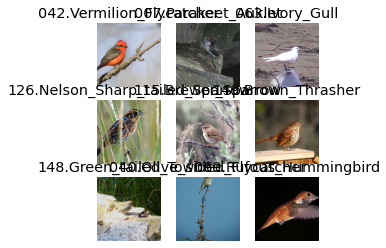

In [ ]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42), #10% of the training set will be used for validation
    get_y=parent_label,
    item_tfms = Resize(224), # so our images have the same size as ImageNet images (the dataset in which ResNet18 was pretrained on)
    batch_tfms = [] # Normalize data with ImageNet stats
)

birdsdl=birds.dataloaders(path/"train") # dowload tha dataset and use the DataBlock definition to create the training dataset
birdsdl.show_batch(max_n=9, figsize=(4,4)) # shows a batch of images

0.0008317637839354575


No improvement since epoch 3: early stopping


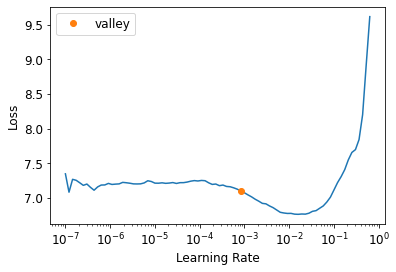

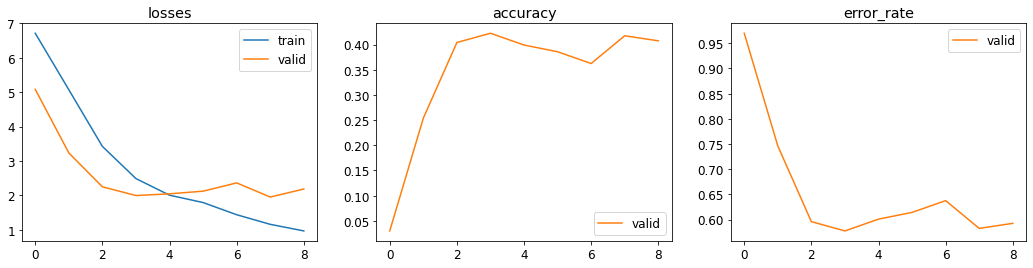

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

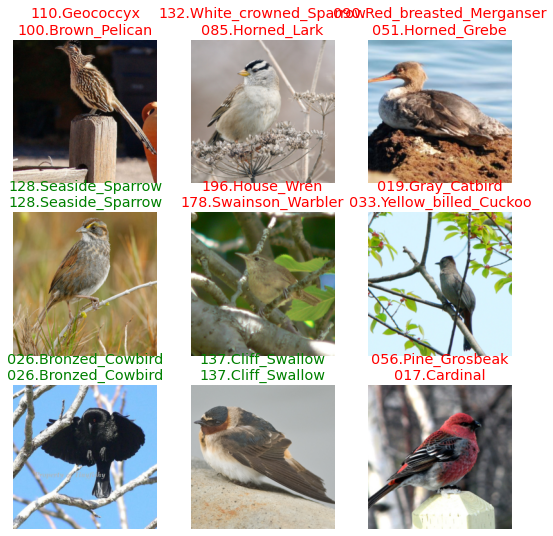

In [ ]:
learn = vision_learner(birdsdl, original)
learn.freeze()
lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(lr[0])
learn.fit_one_cycle(n_epoch=20, lr_max=lr[0]) # running the optimizer one-cycle
learn.recorder.plot_metrics() # shows accuracy curve along epochs
learn.show_results()
learn.summary() # show all details

## Reentrenamiento con nuevo bloque+cabeza diseñado

In [ ]:
designedhead=nn.Sequential(
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3)), 
    nn.BatchNorm2d(512),
    nn.Dropout(p=0.1, inplace=False),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2048, 200)
)

0.00013182566908653826


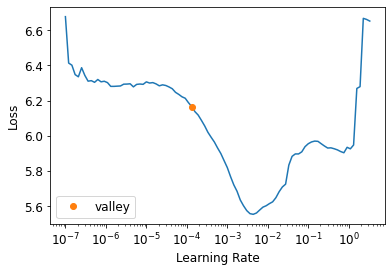

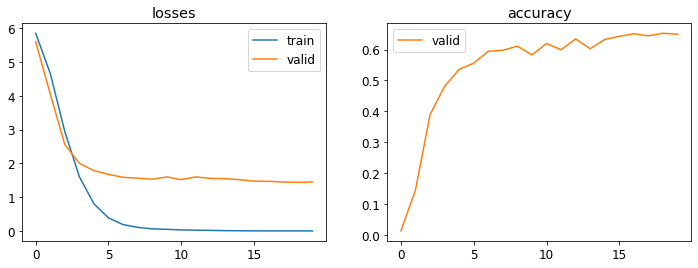

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

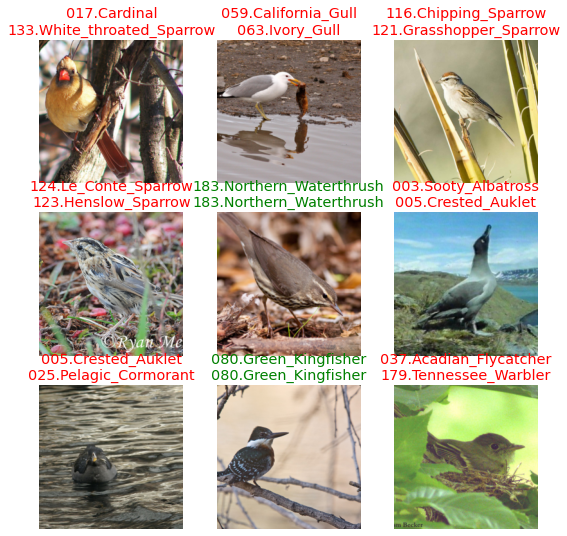

In [ ]:
pt = create_vision_model(models.resnet18, 200, True, n_in=3, custom_head = designedhead)
learn = Learner(birdsdl, pt, metrics=accuracy) # setting the learning scenario
learn.freeze()
lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(lr[0])
learn.fit_one_cycle(n_epoch=20, lr_max=lr[0]) # running the optimizer one-cycle
learn.recorder.plot_metrics() # shows accuracy curve along epochs
learn.show_results()
learn.summary() # show all details

## Ajuste fino de los modelos anteriores


In [ ]:
origin = models.resnet18

In [ ]:
learn = vision_learner(birdsdl, origin)
learn.fine_tune(10)

KeyboardInterrupt: ignored

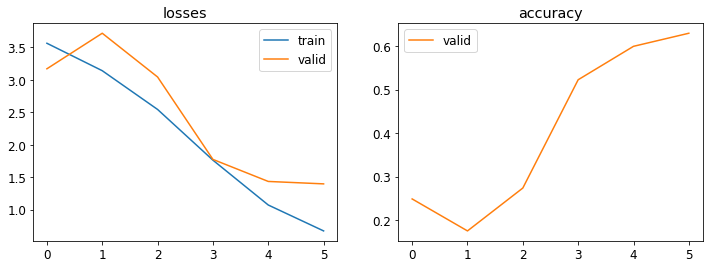

In [ ]:
learn.recorder.plot_metrics()

---



---



---

# **Bonus. (3 points)**  

There are many other possibilities to improve the *BaseNet* model over CIFAR100 using suitable combinations of layers. Feel free to try your own ideas, or those interesting machine learning and computer vision approaches you've read about. Student proposals are expected for discussion and clear definition. Each proposal will be evaluated based on its innovation, complexity, and good use of PyTorch+Fastai. We will also take the mastering of the libraries used in the experiment into consideration.

**Note 1**: The Bonus will only be taken into account if, at least, 75% of the compulsory part is correct. 

**Note 2**: Since Colab only offers limited computational resources, students must try to rationally limit training time, memory consumption and size of the models used. The use of good coding practices is highly advised.